In the paper, the lattice constant a=1 nm, and the Fermi energy is taken as E_F=3 meV.
However, if also use the magnetic topological insulator model for the leads, the E_F need to take values higher than about 8 meV to avoid the gap region in the small m cases.

The center is MTI ,and the leads are EG.

In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import tinyarray

sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

I_4= tinyarray.array(np.kron(sigma_0, sigma_0))
gamma_1 = tinyarray.array(np.kron(sigma_0, sigma_z))
gamma_2 = tinyarray.array(np.kron(sigma_z, sigma_z))
gamma_3 = tinyarray.array(np.kron(sigma_0, sigma_y))
gamma_4 = tinyarray.array(np.kron(sigma_0, sigma_x))

B=-300
g=300
las=1

structure=kwant.lattice.square(las,norbs=4)
model_sym= kwant.TranslationalSymmetry(structure.vec((-1,0)),structure.vec((0,-1)))

def onsite(site,m):
    return m/2*gamma_1 - (4*B)/las**2 * gamma_2

hopping_x = B/(las**2)*gamma_2 + 1j*g/(2*las)*gamma_3
hopping_y = B/(las**2)*gamma_2 - 1j*g/(2*las)*gamma_4

def model_MTI():
    model_1= kwant.Builder(model_sym)

    model_1[structure(0, 0)] = onsite
    model_1[kwant.builder.HoppingKind((1,0), structure)]  = hopping_x
    model_1[kwant.builder.HoppingKind((0,1), structure)]  = hopping_y

    return model_1

def model_EG():

    onsite_leads= 150 *I_4
    hopping_leads= -150 *I_4

    model_2= kwant.Builder(model_sym)
    model_2[structure(0, 0)] = onsite_leads
    model_2[structure.neighbors()]  = hopping_leads

    return model_2

def make_syst(width=50,length=100,leads_model=model_EG()):
    
    ########### create the scattering center

    def shape_center(site):
        x, y = site.pos
        return 0 < x <= length and 0 < y <= width

    syst= kwant.Builder()
    syst.fill(model_MTI(), shape_center,(1,1))

    ########### create the leads

    width_lead = length//5

    lead0= kwant.Builder(kwant.TranslationalSymmetry((-1,0)))
    lead1= kwant.Builder(kwant.TranslationalSymmetry((0,1)))
    lead2= kwant.Builder(kwant.TranslationalSymmetry((0,1)))

    def shape_lead0(site):
        x, y = site.pos
        return 0 < y <= width

    def shape_lead1(site):
        x, y = site.pos
        return width_lead < x <= 2*width_lead

    def shape_lead2(site):
        x, y = site.pos
        return 3*width_lead < x <= 4*width_lead

    lead0.fill(leads_model, shape_lead0, (0, 1))
    lead1.fill(leads_model, shape_lead1, (width_lead+1, 0))
    lead2.fill(leads_model, shape_lead2, (3*width_lead+1, 0))

    ########### create the six-terminal device
    for lead in [lead0,lead1,lead2, lead0.reversed(),lead2.reversed(),lead1.reversed()]:
        syst.attach_lead(lead)

    return syst.finalized()


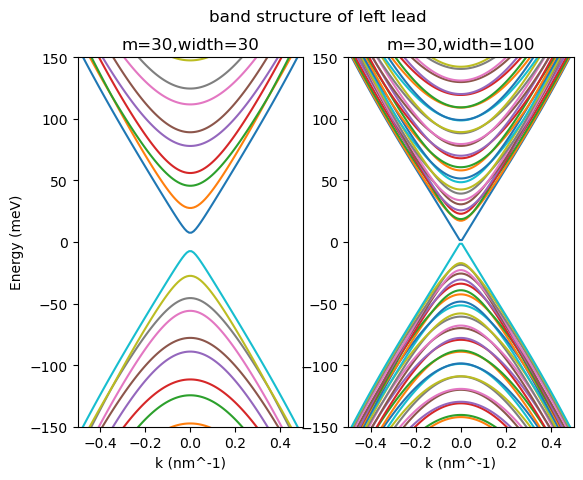

In [2]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('band structure of left lead')

ax1.set_ylabel('Energy (meV)')
ax1.set_title('m=30,width=30')
ax2.set_title('m=30,width=100')
for ax in (ax1,ax2):
    ax.set_xlabel('k (nm^-1)')
    ax.set_ylim(-150,150)
    ax.set_xlim(-0.5,0.5)

syst1=make_syst(width=30,leads_model=model_MTI()).leads[0]
syst2=make_syst(width=100,leads_model=model_MTI()).leads[0]

kwant.plotter.bands(syst1,momenta=np.linspace(-0.5, 0.5, 100), ax=ax1, params=dict(m=30));
kwant.plotter.bands(syst2,momenta=np.linspace(-0.5, 0.5, 100), ax=ax2, params=dict(m=30));

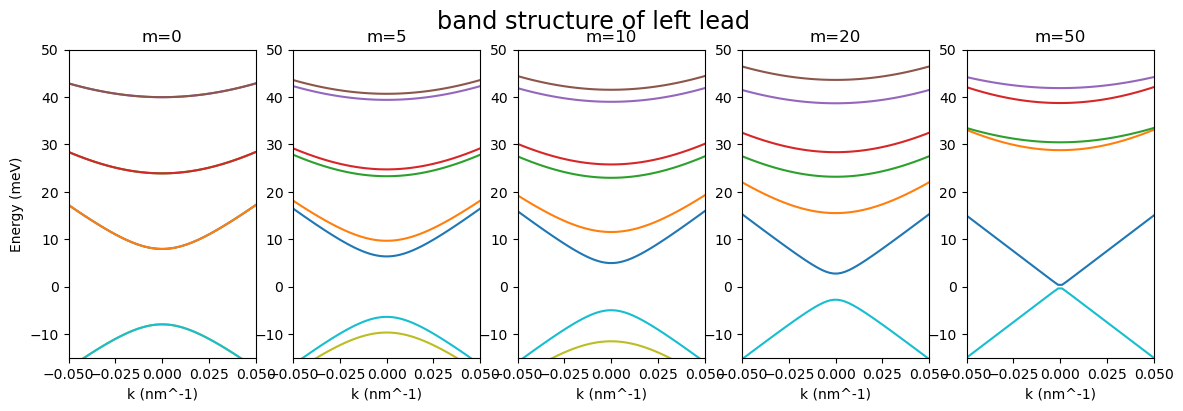

In [3]:
syst1=make_syst(width=60,leads_model=model_MTI()).leads[0]

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize=(14, 4))
fig.suptitle('band structure of left lead', size='xx-large')

ax1.set_ylabel('Energy (meV)')
for ax in zip((ax1,ax2,ax3,ax4,ax5),(0,5,10,20,50)):
    ax[0].set_xlabel('k (nm^-1)')
    ax[0].set_ylim(-15,50)
    ax[0].set_xlim(-0.05,0.05)
    ax[0].set_title(f'm={ax[1]}')
    kwant.plotter.bands(syst1,momenta=np.linspace(-0.05, 0.05, 50), ax=ax[0], params=dict(m=ax[1]));


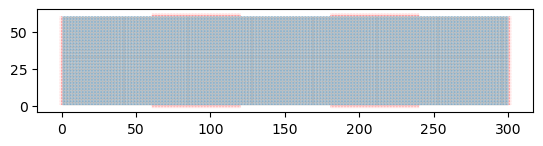

In [4]:
syst=make_syst(width=60,length=300,leads_model=model_MTI())
kwant.plot(syst);

In [5]:
tmatrix = kwant.smatrix(syst, 3.0,params=dict(m=10))
tm=tmatrix.conductance_matrix()
np.round(tm,2)

array([[-0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0.]])

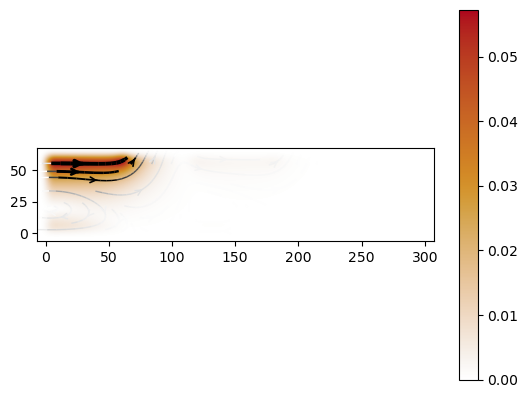

In [6]:
fsyst = make_syst(width=60,length=300,leads_model=model_MTI())

J=kwant.operator.Current(fsyst)            #这个对象是一个电流算符，可以用来计算系统 fsyst 中任意两个相邻格点（跳跃，hopping）之间的局部电流密度。wf[0][0] 通常表示从第一个引线注入的波函数在第一个自旋/轨道通道中的分量（具体取决于模型的自由度）。
wf=kwant.wave_function(fsyst, energy=8,params=dict(m=20))  #它是一个包含了已计算好的散射波函数集合的对象。
psi=wf(0)[0]                               #为什么只有一个一个轨道模型
current = J(psi)
kwant.plotter.current(fsyst, current, colorbar=True, show=True)

In [7]:
#计算传输模式及其数目
#compute_first_lead_modes(fsyst, energy=8, params=dict(m=20))

In [8]:
def find_voltages(tmatrix,current):
    try:
        voltage = np.linalg.solve(tmatrix[1:, 1:], current[1:])
    except np.linalg.LinAlgError as err:
        if 'Singular matrix' in str(err):
            print("Hi there, singular matrix here")
            voltage = [0,0,0,0,0]
        else:
            raise
    return [0, *voltage]

def resistance_xx(tmatrix):
    current = [1, 0, 0, -1, 0, 0]
    voltage = find_voltages(tmatrix,current)
    
    def resistance(lead1, lead2):
        return voltage[lead1-1]-voltage[lead2-1]

    return resistance(2, 3)

def resistance_xy(tmatrix):
    current = [1, 0, 0, -1, 0, 0]
    voltage = find_voltages(tmatrix,current)
    
    def resistance(lead1, lead2):
        return voltage[lead1-1]-voltage[lead2-1]

    return resistance(2, 6)

def rMplot(m_list, data, ptitle='resistance vs m'):
    rxx=[]
    rxy=[]
    for i in range(data.shape[0]):
        rxx.append(resistance_xx(data[i]))
        rxy.append(resistance_xy(data[i]))

    plt.plot(m_list,rxx,'-o', label='$R_{xx}$')
    plt.plot(m_list,rxy,'-o', label='$R_{xy}$')

    plt.title(ptitle, size='xx-large')
    plt.xlabel('m')
    plt.ylabel('Resistance')
    plt.legend()


# define a function to plot the resistance vs energy
# here, "data" is a "np.array", a list (different energy) of 6*6 transimission matrices=[]
def rEplot(energies, data, ptitle='resistance vs energy'):
    rxx=[]
    rxy=[]
    for i in range(data.shape[0]):
        rxx.append(resistance_xx(data[i]))
        rxy.append(resistance_xy(data[i]))

    plt.plot(energies,rxx,'-o', label='$R_{xx}$')
    plt.plot(energies,rxy,'-o', label='$R_{xy}$')

    plt.title(ptitle, size='xx-large')
    plt.xlabel('Energy')
    plt.ylabel('Resistance')
    plt.legend()



In [9]:
data=[]
m_range=np.linspace(-50,50,num=50)
for m_value in m_range:
    tmatrix = kwant.smatrix(syst, 9.0,params=dict(m=m_value))
    data.append(tmatrix.conductance_matrix())

# cost around 2 mins

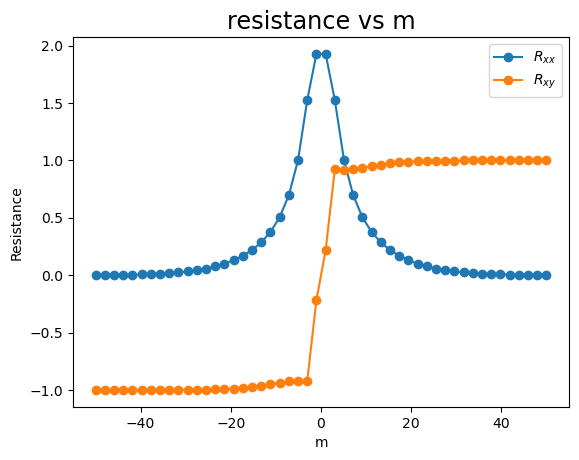

In [10]:
rMplot(m_range,np.array(data))

In [11]:
np.round(data[6],2)

array([[ 1.  , -1.  , -0.  , -0.  , -0.  , -0.  ],
       [-0.  ,  1.  , -0.99, -0.  , -0.  , -0.01],
       [-0.  , -0.  ,  1.  , -1.  , -0.  , -0.  ],
       [-0.  , -0.  , -0.  ,  1.  , -1.  , -0.  ],
       [-0.  , -0.  , -0.01, -0.  ,  1.  , -0.99],
       [-1.  , -0.  , -0.  , -0.  , -0.  ,  1.  ]])

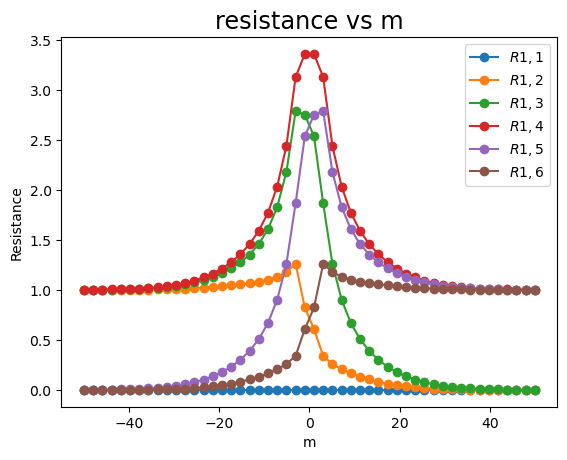

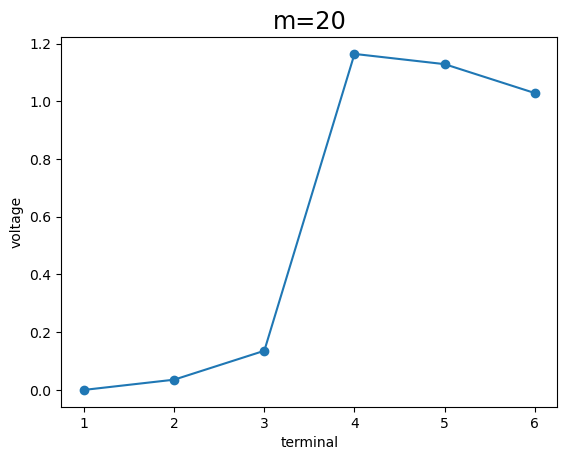

In [12]:
# One m, one resistance
r=[]
def rMplot_m(m_list, data, lead1=2,lead2=5, ptitle='resistance vs m'):
    current = [1, 0, 0, -1, 0, 0]
    rx=[]
    for i in range(data.shape[0]):
        voltage = find_voltages(data[i],current)
        rx.append(voltage[lead1-1]-voltage[lead2-1])
    r.append(rx[35])
    plt.plot(m_list,rx,'-o', label=f'$R {lead1},{lead2}$')

    plt.title(ptitle, size='xx-large')
    plt.xlabel('m')
    plt.ylabel('Resistance')
    plt.legend()
# double 3
rMplot_m(m_range,np.array(data),1,1)
rMplot_m(m_range,np.array(data),1,2)
rMplot_m(m_range,np.array(data),1,3)
rMplot_m(m_range,np.array(data),1,4)
rMplot_m(m_range,np.array(data),1,5)
rMplot_m(m_range,np.array(data),1,6)
plt.show()

#voltage vs n
np.round(r,2)
num=[]
for i in range(7):
    num.append(i)
del num[0]
plt.plot(num,r,'-o', label='R')
plt.title("m=20", size='xx-large')
plt.xlabel('terminal')
plt.ylabel('voltage')
plt.show()


In [13]:
syst1=make_syst(width=60,leads_model=model_MTI()).leads[0]

In [14]:
bands = kwant.physics.Bands(syst1, params=dict(m=0))
momenta=np.linspace(-0.05, 0.05, 200)

es=[]         # eigenvalues （200,240）
evs=[]        # eigenvectors （200,240,240）
for k in momenta:
    tem_a,tem_b= bands(k=k,return_eigenvectors = True) 
    es.append(tem_a)
    evs.append(tem_b) 

In [15]:
[np.array(es).shape, np.array(evs).shape]

# 200 k points (momenta) are taken, that is 200 states
# there are 60 sites, and each site has a freedom of 4. Therefore, the freedom (dimension of matrix, number of bands) is 240 for each state

[(200, 240), (200, 240, 240)]

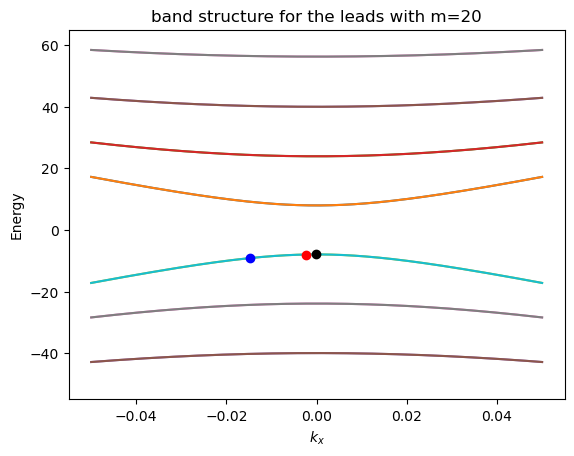

In [16]:
# the 100th, 96th and 70th states (k values) are chosen, the 120th energy level (band) is chosen
plt.plot(momenta,es);
plt.plot(momenta[99], es[99][119], 'ko')
plt.plot(momenta[95], es[95][119], 'ro')
plt.plot(momenta[70], es[70][119], 'bo')
plt.ylim(-55,65)
plt.xlabel('$k_x$')
plt.ylabel('Energy')
plt.title('band structure for the leads with m=20');

[(240,), (240,), (240,), (60, 4), (60,)]

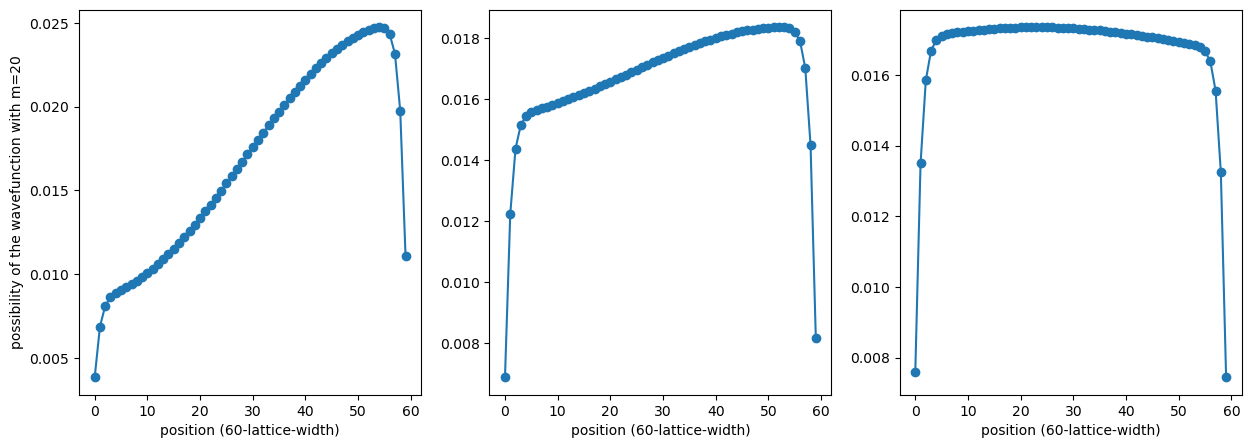

In [17]:
swf1=np.abs(evs[70][:,119])**2       #evs储存了200的k点的波函数（240✖️240）「第x列代表了第x能级的波函数，其波函数有240个分量」，evs[70]是第70个k点的波函数，evs[70][:,10]是第70个k点的第10个能级的波函数
swf2=np.abs(evs[95][:,119])**2       #[:,10] equals to the sumption of [0,10][1,10][2,10][3,10].... [240,10]
swf3=np.abs(evs[99][:,119])**2
fig,(ax1,ax2,ax3)=plt.subplots(1,3, figsize=(15,5))
ax1.plot(range(60),swf1.reshape((-1,4)).sum(1),'-o')
ax2.plot(range(60),swf2.reshape((-1,4)).sum(1),'-o')
ax3.plot(range(60),swf3.reshape((-1,4)).sum(1),'-o')

for ax in (ax1,ax2,ax3):
    ax.set_xlabel('position (60-lattice-width)')
ax1.set_ylabel('possibility of the wavefunction with m=20')

# 1. take the absolute value of the wavefunction and make the square
# 2. split the "array1" into parts (each parts has 4 values, i.e. the inner freedom of 4 at the same site is grouped) by using np.reshape(array1,(-1,4)), check the example-1 below
# 3. sum the parts splitted, i.e. sum the inner freedom of 4

swf2=np.abs(evs[70][:,119])
[np.array(swf2).shape,np.array(swf2**2).shape,np.array(swf2**3).shape,np.array(swf2).reshape((-1,4)).shape,np.array(swf2).reshape((-1,4)).sum(1).shape]
#SWF2 = np.array([11, 12, 33, 4, 5, 6, 7, 88])
#SWF2.reshape((-1, 4))             [[11, 12, 33,  4],[ 5,  6,  7, 88]]
#SWF2.reshape((-1, 4)).sum(1)      [60, 106]



In [18]:
zcolors=[]                     # momenta=np.linspace(-0.05, 0.05, 200)
for k in range(len(momenta)):  # for k in momenta:，这个k为波矢    len(momenta)=200   
    tem_1=[]                   # tem_1=[]是一个空列表
    for i in range(np.array(es).shape[1]):                                   # np.array(es).shape=(200, 240); np.array(es).shape[1]=240,输出240（即二维数组的列数）
            swf=np.reshape(np.abs(evs[k][:,i])**2,(-1,2)).sum(1)             ####reshape函数的另一种使用法
            tem_c=swf.reshape(2,-1).sum(1)
            tem_1.append(tem_c[0]-tem_c[1])
    zcolors.append(tem_1)

# 1. take the absolute value of the i-th wavefunction and make the square
# 2. split the "array1" into parts (each parts has 4 values, i.e. the inner freedom of 4 at the same site is grouped) by using np.reshape(array1,(-1,4)), check the example-1 below
# 3. sum the parts splitted, i.e. sum the inner freedom of 4
# 4. in a similliar way, split the "array2" into two parts (two half part of sites) and sum each part by using "array2.reshape(2,-1).sum(1)"
# 5. use the one sum of parts substract the other one.

np.array(zcolors).shape

(200, 240)

In [19]:
# example-1
a = np.arange(16)
a, a.reshape(-1,4), np.reshape(a,(-1,4)).sum(1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]]),
 array([ 6, 22, 38, 54]))

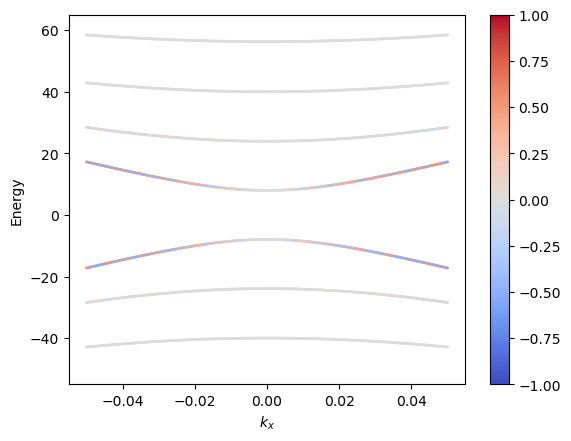

In [20]:
for i in range(np.array(es).shape[1]):
    plt.scatter(momenta,np.array(es)[:,i],s=1,c=np.array(zcolors)[:,i],cmap="coolwarm",vmin=-1.,vmax=1.)
plt.ylim(-55,65)
plt.xlabel('$k_x$')
plt.ylabel('Energy')
plt.colorbar();

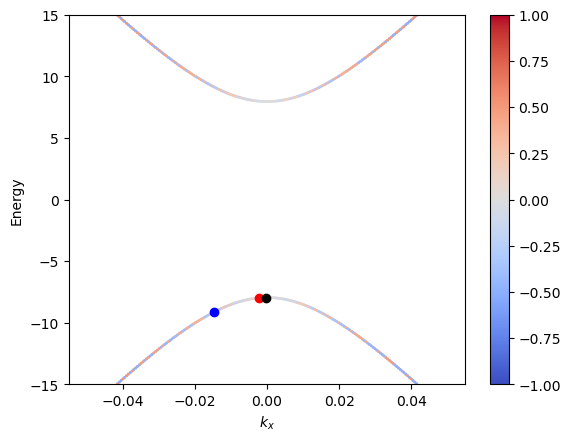

In [21]:
for i in range(np.array(es).shape[1]):
    plt.scatter(momenta,np.array(es)[:,i],s=1,c=np.array(zcolors)[:,i],cmap="coolwarm",vmin=-1.,vmax=1.)
plt.plot(momenta[70], es[70][119], 'bo')
plt.plot(momenta[95], es[95][119], 'ro')
plt.plot(momenta[99], es[99][119], 'ko')
plt.ylim(-15,15)
plt.xlabel('$k_x$')
plt.ylabel('Energy')
plt.colorbar();

In [22]:
data=[]
for energy in np.linspace(-20,20,num=20):
    tmatrix = kwant.smatrix(syst, energy,params=dict(m=30))
    data.append(tmatrix.conductance_matrix())